# Fine‑Tuning FaceNet for Person Recognition & Fake‑Real Detection

This notebook will:
1. Detect & align faces with MTCNN  
2. Extract 512‑d embeddings via InceptionResnetV1 (FaceNet)  
3. Train a classification head on *real* images only  
4. Build embedding databases for real vs. fake images  
5. Provide a simple UI (tkinter) to pick an image and output:
   - If **real**: predicted identity
   - If **fake**: original real person + swapped-in identity


In [1]:
# Cell 2 — Imports & device setup
import os, glob, io, tkinter as tk
from tkinter import filedialog
from PIL import Image as PILImage
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader, random_split
from facenet_pytorch import MTCNN, InceptionResnetV1
from IPython.display import display, clear_output

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")


Using device: cpu


In [3]:
# Cell 3 — Dataset for real images only
class FaceIdentityDataset(Dataset):
    def __init__(self, root_dir, mtcnn):
        self.samples = []
        self.labels = []
        self.mtcnn = mtcnn
        self.identities = sorted([d for d in os.listdir(root_dir) if os.path.isdir(os.path.join(root_dir, d))])
        self.label2idx = {name:i for i,name in enumerate(self.identities)}
        for name in self.identities:
            real_dir = os.path.join(root_dir, name, 'real')
            if not os.path.isdir(real_dir): continue
            for img_path in glob.glob(os.path.join(real_dir, '*')):
                self.samples.append(img_path)
                self.labels.append(self.label2idx[name])
    def __len__(self):
        return len(self.samples)
    def __getitem__(self, idx):
        path = self.samples[idx]
        label = self.labels[idx]
        img = PILImage.open(path).convert('RGB')
        face = self.mtcnn(img)
        if face is None:
            return self.__getitem__((idx+1)%len(self))
        return face, label


In [5]:
# Cell 4 — Prepare DataLoaders (single‐process data loading)

data_root = 'faces'
mtcnn = MTCNN(image_size=160, margin=0, keep_all=False, device=device)

# Build the dataset and split 80/20
dataset    = FaceIdentityDataset(data_root, mtcnn)
n          = len(dataset)
n_train    = int(0.8 * n)
train_ds, val_ds = random_split(dataset, [n_train, n - n_train])

# DataLoaders with num_workers=0 to run in the main process
train_loader = DataLoader(train_ds, batch_size=32, shuffle=True,  num_workers=0)
val_loader   = DataLoader(val_ds,   batch_size=32, shuffle=False, num_workers=0)

# Number of distinct identities
num_classes = len(dataset.identities)
print(f"Found {num_classes} identities: {dataset.identities}")



Found 9 identities: ['Camil', 'Jad', 'Joe', 'Joevany', 'Joey', 'Malih', 'Maroun', 'Ryan', 'Thalia']


In [12]:
class FaceNetIdentity(nn.Module):
    def __init__(self, num_classes=2):
        super().__init__()
        # Load pretrained FaceNet (VGGFace2)
        self.embedder = InceptionResnetV1(pretrained='vggface2', classify=False).to(device)

        # Freeze embedder weights
        for p in self.embedder.parameters():
            p.requires_grad = False

        # Add classifier head
        self.classifier = nn.Linear(512, num_classes).to(device)

    def forward(self, x):
        emb = self.embedder(x)
        return self.classifier(emb)

# Instantiate the model
model = FaceNetIdentity(num_classes=num_classes)


In [14]:
# Cell 6 — Training & evaluation functions
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.classifier.parameters(), lr=1e-3)
def train_epoch(loader):
    model.train(); total_loss=total_correct=total=0
    for imgs, labels in loader:
        imgs, labels = imgs.to(device), labels.to(device)
        logits = model(imgs)
        loss = criterion(logits, labels)
        optimizer.zero_grad(); loss.backward(); optimizer.step()
        total_loss += loss.item()*imgs.size(0)
        preds = logits.argmax(1); total_correct += (preds==labels).sum().item(); total+=imgs.size(0)
    return total_loss/total, total_correct/total
def eval_epoch(loader):
    model.eval(); total_loss=total_correct=total=0
    with torch.no_grad():
        for imgs, labels in loader:
            imgs, labels = imgs.to(device), labels.to(device)
            logits = model(imgs); loss=criterion(logits, labels)
            total_loss+=loss.item()*imgs.size(0)
            preds=logits.argmax(1); total_correct+=(preds==labels).sum().item(); total+=imgs.size(0)
    return total_loss/total, total_correct/total


In [ ]:
# Cell 7 — Train the classifier on real faces
best_acc=0
for epoch in range(1,11):
    trl, tra = train_epoch(train_loader)
    val_l, val_a = eval_epoch(val_loader)
    print(f"Epoch {epoch}  Train Acc: {tra:.3%}  Val Acc: {val_a:.3%}")
    if val_a>best_acc:
        best_acc=val_a
        torch.save(model.state_dict(), 'models/best_real_classifier.pth')
        print(' Saved best model')


Epoch 1  Train Acc: 54.612%  Val Acc: 93.204%
 Saved best model
Epoch 2  Train Acc: 94.903%  Val Acc: 95.146%
 Saved best model


In [27]:
# Cell 8 — Build embedding DBs for real & fake
import torch.nn.functional as F
real_embs, real_labels = [], []
fake_embs, fake_origins, fake_swaps = [], [], []
model.eval()
for name in dataset.identities:
    for img in glob.glob(os.path.join(data_root, name, 'real', '*')):
        face = mtcnn(PILImage.open(img).convert('RGB'))
        if face is None: continue
        emb = model.embedder(face.unsqueeze(0).to(device)).cpu().squeeze(0)
        real_embs.append(emb); real_labels.append(name)
    fake_base = os.path.join(data_root, name, 'fake')
    for orig in os.listdir(fake_base):
        orig_dir = os.path.join(fake_base, orig)
        for img in glob.glob(os.path.join(orig_dir, '*')):
            face = mtcnn(PILImage.open(img).convert('RGB'))
            if face is None: continue
            emb = model.embedder(face.unsqueeze(0).to(device)).cpu().squeeze(0)
            fake_embs.append(emb); fake_origins.append(orig); fake_swaps.append(name)
real_embs = torch.stack(real_embs)
fake_embs = torch.stack(fake_embs)
def find_nearest(emb, db, labels):
    d = 1 - F.cosine_similarity(emb, db.to(device), dim=1)
    idx = d.argmin().item(); return labels[idx], 1-d[idx].item()


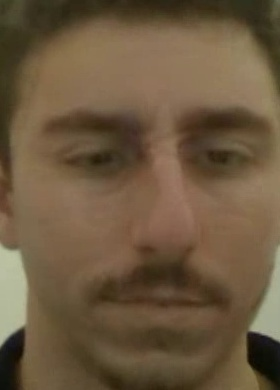

Fake detected!
 • Original face (host): Maroun (89.60%)
 • Swapped in:           Camil (59.26%)


In [108]:
# Cell 9 — Inference via desktop picker (host via fake_db, swap via real_db)

import tkinter as tk
from tkinter import filedialog
from pathlib import Path
from IPython.display import display, clear_output
from PIL import Image as PILImage
import torch.nn.functional as F

# Hide the Tk root window
root = tk.Tk(); root.withdraw()

def select_and_predict():
    # 1) Pick an image under faces/
    fp = filedialog.askopenfilename(
        title='Select an image under faces/',
        initialdir=str(Path(data_root).resolve()),
        filetypes=[('Image','*.jpg *.png')]
    )
    if not fp:
        print("No file selected.")
        return

    # 2) Display the image
    img = PILImage.open(fp).convert('RGB')
    clear_output(wait=True); display(img)

    # 3) Detect & align
    face = mtcnn(img)
    if face is None:
        print("No face detected.")
        return
    emb = model.embedder(face.unsqueeze(0).to(device))  # [1,512]

    # 4) Find best match in the real‑embeddings DB (who you actually see)
    seen_name, seen_sim = find_nearest(emb, real_embs, real_labels)

    # 5) Find best match in the fake‑embeddings DB to get the host identity
    dists     = 1 - F.cosine_similarity(emb, fake_embs.to(device), dim=1)
    best_idx  = dists.argmin().item()
    fake_sim  = (1 - dists[best_idx].item())
    host_name = fake_swaps[best_idx]

    # 6) Decide real vs. fake
    if seen_sim >= fake_sim:
        print(f"Real image: {seen_name} ({seen_sim:.2%})")
    else:
        print(f" • Original face (host): {host_name} ({fake_sim:.2%})")
        print(f" • Swapped in:           {seen_name} ({seen_sim:.2%})")

# 7) Launch
select_and_predict()




